In [168]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from ot.gaussian import bures_wasserstein_distance
from conditioningMaps import build_regression_problem
plt.style.use('ggplot')
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge

In [169]:
num_grid_points = 5
num_cond_points = 2

grid_points = np.linspace(0,1,num_grid_points)


observation_variance = 0.1

def k(x,y,gamma=0.2):
    return np.exp(-1*np.sum((x-y)**2)/gamma)

cond_points = np.array([0.25,0.75])

all_points = np.hstack([cond_points,grid_points])
C = np.array([[k(x,y) for x in all_points] for y in all_points])
C[:num_cond_points,:num_cond_points]+=np.identity(num_cond_points)*observation_variance


C_grid = C[num_cond_points:,num_cond_points:]


posterior_variance = C_grid - C[num_cond_points:,:num_cond_points]@np.linalg.inv(C[:num_cond_points,:num_cond_points])@C[:num_cond_points,num_cond_points:]

In [181]:
num_samples = 500
target_samples = np.random.multivariate_normal(0*all_points,C,size=num_samples)
target_cond = target_samples[:,:num_cond_points]
target_grid = target_samples[:,num_cond_points:]

reference_samples = np.hstack([target_cond,np.random.multivariate_normal(0*grid_points,C_grid,size=num_samples)])

Xreg,yreg=build_regression_problem(
    reference_samples,
    target_samples,
    0.2,
    num_cond_points,
)

Building Cost Matrix
Solving OT Problem
Finished


In [182]:
model = LinearRegression()
model.fit(Xreg,yreg)

KRR = KernelRidge(alpha=1e-5,kernel='rbf',gamma=0.05)
KRR.fit(Xreg,yreg)

num_new_samples = 2000
observed_values = np.array([0.2,-0.3])
posterior_mean = C[num_cond_points:,:num_cond_points] @ np.linalg.inv(C[:num_cond_points,:num_cond_points]) @ observed_values

new_samples = np.hstack(
    [
        np.vstack([observed_values]*num_new_samples),
        np.random.multivariate_normal(0*grid_points,C_grid,size=num_new_samples)
    ]
)

In [183]:
pred_posterior_samples = KRR.predict(new_samples)
pred_cov = np.cov(pred_posterior_samples.T)
pred_mean = np.mean(pred_posterior_samples,axis=0)
bures_wasserstein_distance(pred_mean,posterior_mean,pred_cov,posterior_variance)

1.1212717925749152

In [184]:
A = model.coef_
model_mean = A[:,:num_cond_points]@observed_values
model_cov = A[:,num_cond_points:].T@C_grid@A[:,num_cond_points:]
bures_wasserstein_distance(model_mean,posterior_mean,model_cov,posterior_variance)

0.6183402545120437

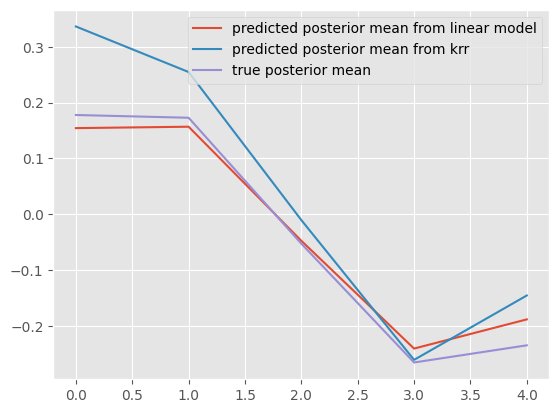

In [185]:
plt.plot(model_mean,label='predicted posterior mean from linear model')
plt.plot(pred_mean,label = 'predicted posterior mean from krr')
plt.plot(posterior_mean,label='true posterior mean')
plt.legend()

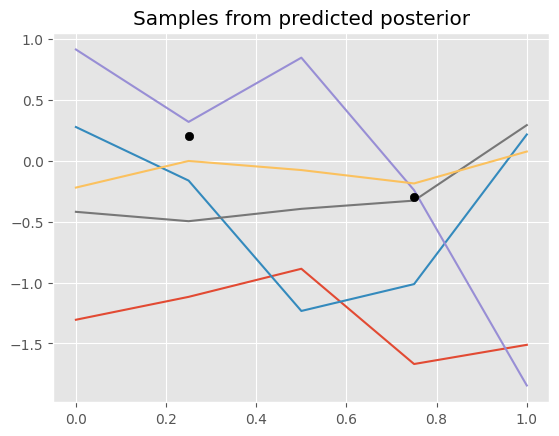

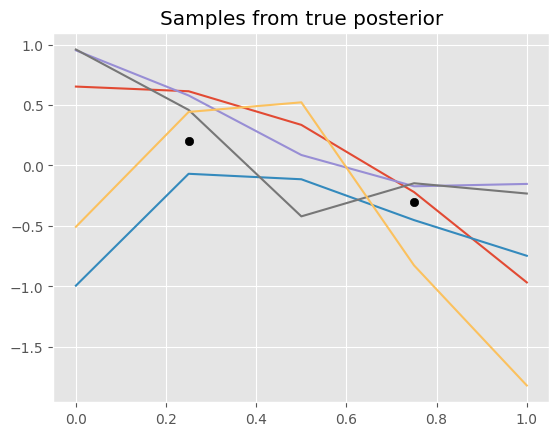

In [186]:
plt.title("Samples from predicted posterior")
for i in range(5):
    plt.plot(grid_points,pred_posterior_samples[i])
plt.scatter(cond_points,observed_values,c='black',zorder=100)
plt.show()

plt.title("Samples from true posterior")
true_posterior_samples = np.random.multivariate_normal(posterior_mean,posterior_variance,size=num_new_samples)
for i in range(5):
    plt.plot(grid_points,true_posterior_samples[i])
plt.scatter(cond_points,observed_values,c='black',zorder=100)
